<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 10.3 PySpark for Big Data

## Introduction

**Note**: this notebook is to be run in Google Colab on your Google Drive. It will not work locally on your computer.

The purpose of this lab is to gain further exposure to cloud computing, often necessary when datasets become too large to manage on a local machine. You will learn how to work with a large dataset through the PySpark Python library with Google Colaboratory (Colab).

In Google Colab, a virtual machine is automatically set up to execute your code. The maximum lifetime of such a machine is 12 hours. Note that notebooks will be disconnected from virtual machines if left idle. If this happens simple click on the Connect button to reconnect. If the kernel needs to be restarted (via the Runtime menu), variables may be lost but packages would not need to be reinstalled unless a new machine is assigned.

https://research.google.com/colaboratory/faq.html

Sign into colab.research.google.com and choose the Upload tab and upload this notebook.  This will automatically create a folder called "Colab Notebooks" in your Google Drive (if it does not already exist).

Apache Spark is an open-source cluster-computing framework, able to work with large datasets quickly by performing in-memory caching and computation. Pyspark is a Python API for Spark commonly used to manipulate big data. For reference one useful cheat sheet is available at https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf


Fortunately Pyspark is straightforward to setup in Google Colab:

In [1]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=79051fc4ab7fd8e40accf8148e81e9d9ebf0e2abfcfc4d02a9aa68f73cbe491b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


To work with Spark DataFrames we firstly need to create a Spark DataFrame:

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, avg, round, when
from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("populationdata").getOrCreate()

In [4]:
spark

## Loading the dataset and EDA

The dataset to be analysed in this lab shows population estimates by age and gender:

   - PopMale: Male population for the individual age (thousands)
   - PopFemale: Female population for the individual age (thousands)
   - PopTotal: Total population for the individual age (thousands)

Further details can be found at https://population.un.org/wpp/.

In [5]:
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# run this cell after uploading the file into your Colab Notebooks folder
df = spark.read.csv(r"/content/drive/MyDrive/Colab Notebooks/WPP2019_PopulationBySingleAgeSex_1950-2019.csv", header=True)

In [8]:
type(df)

pyspark.sql.dataframe.DataFrame

In [9]:
df

DataFrame[LocID: string, Location: string, VarID: string, Variant: string, Time: string, MidPeriod: string, AgeGrp: string, AgeGrpStart: string, AgeGrpSpan: string, PopMale: string, PopFemale: string, PopTotal: string]

Note that unlike Pandas this does not display a preview of the dataset, only the schema. This is because Spark performs lazy evaluation, only displaying rows when needed.

In [10]:
df.columns

['LocID',
 'Location',
 'VarID',
 'Variant',
 'Time',
 'MidPeriod',
 'AgeGrp',
 'AgeGrpStart',
 'AgeGrpSpan',
 'PopMale',
 'PopFemale',
 'PopTotal']

**Exercise**: How many rows does df contain?

In [11]:
# ANSWER
df.count()

3132010

In [12]:
df.rdd.getNumPartitions()

2

This corresponds to the number of cores in a free Google Colab instance.

In [13]:
df.printSchema()

root
 |-- LocID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- MidPeriod: string (nullable = true)
 |-- AgeGrp: string (nullable = true)
 |-- AgeGrpStart: string (nullable = true)
 |-- AgeGrpSpan: string (nullable = true)
 |-- PopMale: string (nullable = true)
 |-- PopFemale: string (nullable = true)
 |-- PopTotal: string (nullable = true)



We use df.show() similarly to df.head() in Pandas.

In [14]:
df.show()

+-----+-----------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|LocID|   Location|VarID|Variant|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|PopMale|PopFemale|PopTotal|
+-----+-----------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|    4|Afghanistan|    2| Medium|1950|   1950.5|     0|          0|         1|139.669|  154.913| 294.582|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     1|          1|         1|131.916|  141.851| 273.767|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     2|          2|         1|125.127|  130.632| 255.759|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     3|          3|         1| 119.22|  121.097| 240.317|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     4|          4|         1|114.112|  113.085| 227.197|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     5|          5|         1|109.723|  106.436| 216.159|
|    4|Afghanistan|    2| Medium|1950|   1950.

In [15]:
df.describe()

DataFrame[summary: string, LocID: string, Location: string, VarID: string, Variant: string, Time: string, MidPeriod: string, AgeGrp: string, AgeGrpStart: string, AgeGrpSpan: string, PopMale: string, PopFemale: string, PopTotal: string]

Once again evaluation of describe is lazy, we use show() to display results:

In [16]:
df.describe().show()

+-------+------------------+-----------+-------+-------+------------------+------------------+----------------+----------------+-------------------+------------------+------------------+------------------+
|summary|             LocID|   Location|  VarID|Variant|              Time|         MidPeriod|          AgeGrp|     AgeGrpStart|         AgeGrpSpan|           PopMale|         PopFemale|          PopTotal|
+-------+------------------+-----------+-------+-------+------------------+------------------+----------------+----------------+-------------------+------------------+------------------+------------------+
|  count|           3132010|    3132010|3132010|3132010|           3132010|           3132010|         3132010|         3132010|            3132010|           3132010|           3132010|           3132010|
|   mean|1077.6884875846501|       NULL|    2.0|   NULL|            1984.5|            1985.0|            50.0|            50.0| 0.9801980198019802|2184.5058436405843|2150.7069

Let us remove rows we do not need.

In [17]:
df.select('VarID', 'Variant').distinct().show()

+-----+-------+
|VarID|Variant|
+-----+-------+
|    2| Medium|
+-----+-------+



As we will not work with other variant, we can safely drop these columns.

In [18]:
df = df.drop('VarID', 'Variant')

In [19]:
df.show()

+-----+-----------+----+---------+------+-----------+----------+-------+---------+--------+
|LocID|   Location|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|PopMale|PopFemale|PopTotal|
+-----+-----------+----+---------+------+-----------+----------+-------+---------+--------+
|    4|Afghanistan|1950|   1950.5|     0|          0|         1|139.669|  154.913| 294.582|
|    4|Afghanistan|1950|   1950.5|     1|          1|         1|131.916|  141.851| 273.767|
|    4|Afghanistan|1950|   1950.5|     2|          2|         1|125.127|  130.632| 255.759|
|    4|Afghanistan|1950|   1950.5|     3|          3|         1| 119.22|  121.097| 240.317|
|    4|Afghanistan|1950|   1950.5|     4|          4|         1|114.112|  113.085| 227.197|
|    4|Afghanistan|1950|   1950.5|     5|          5|         1|109.723|  106.436| 216.159|
|    4|Afghanistan|1950|   1950.5|     6|          6|         1|105.969|   100.99| 206.959|
|    4|Afghanistan|1950|   1950.5|     7|          7|         1|102.769|   96.58

In [20]:
df.select('Location').distinct().count()

440

In [21]:
df.select('Location').distinct().show()

+--------------------+
|            Location|
+--------------------+
|       Côte d'Ivoire|
| LLDC: Latin America|
|                Chad|
|ESCAP: income groups|
|          Cabo Verde|
|       ECE: UNECE-52|
|ESCAP: ADB Develo...|
|  ESCAP: high income|
|Economic Cooperat...|
|            Kiribati|
|Europe and Northe...|
|ECLAC: The Caribbean|
|              Guyana|
|             Eritrea|
|Land-locked Count...|
|            Djibouti|
|ESCWA: Arab least...|
|ESCWA: Maghreb co...|
|                Fiji|
|      ESCAP: low HDI|
+--------------------+
only showing top 20 rows



**Exercise**: Repeat the above query, this time ordering the results by Location and using the truncate=False option to display results in full. Show all 440 results.

In [22]:
# ANSWER
df.select('Location').distinct().orderBy('Location').show(440, truncate=False)

+-----------------------------------------------------------------------------------------+
|Location                                                                                 |
+-----------------------------------------------------------------------------------------+
|Afghanistan                                                                              |
|Africa                                                                                   |
|African Group                                                                            |
|African Union                                                                            |
|African Union: Central Africa                                                            |
|African Union: Eastern Africa                                                            |
|African Union: Northern Africa                                                           |
|African Union: Southern Africa                                                 

Next run the following to confirm that there are no missing values in this dataset:

In [23]:
df.count() - df.na.drop().count()

0

## Convert types

We saw above that all columns are in the form of strings. The following cell converts some of the columns to type float.

In [24]:
floatcols = ['MidPeriod', 'PopMale', 'PopFemale', 'PopTotal']

for col_name in floatcols:
    df = df.withColumn(col_name, trim(col(col_name)).cast('float'))

**Exercise**: Similarly convert the four columns listed below into **integers**.

In [25]:
intcols = ['Time', 'AgeGrp', 'AgeGrpStart', 'AgeGrpSpan']

#ANSWER
for col_name in intcols:
    df = df.withColumn(col_name, trim(col(col_name)).cast('int'))

In [26]:
df.printSchema()

root
 |-- LocID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- MidPeriod: float (nullable = true)
 |-- AgeGrp: integer (nullable = true)
 |-- AgeGrpStart: integer (nullable = true)
 |-- AgeGrpSpan: integer (nullable = true)
 |-- PopMale: float (nullable = true)
 |-- PopFemale: float (nullable = true)
 |-- PopTotal: float (nullable = true)



## Answering some queries about the data

We use filter to select a subset of rows satifying a True/False condition:

Example: What was the population breakdown by age and gender in Australia in 1970?

In [27]:
df.filter((df.Location == 'Australia') & (df.Time == 1970)).show(101)

+-----+---------+----+---------+------+-----------+----------+-------+---------+--------+
|LocID| Location|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|PopMale|PopFemale|PopTotal|
+-----+---------+----+---------+------+-----------+----------+-------+---------+--------+
|   36|Australia|1970|   1970.5|     0|          0|         1|126.482|   121.47| 247.952|
|   36|Australia|1970|   1970.5|     1|          1|         1|126.326|  120.997| 247.323|
|   36|Australia|1970|   1970.5|     2|          2|         1|126.439|  120.829| 247.268|
|   36|Australia|1970|   1970.5|     3|          3|         1|126.751|  120.899|  247.65|
|   36|Australia|1970|   1970.5|     4|          4|         1|127.193|   121.14| 248.333|
|   36|Australia|1970|   1970.5|     5|          5|         1|127.698|  121.488| 249.186|
|   36|Australia|1970|   1970.5|     6|          6|         1|128.196|  121.877| 250.073|
|   36|Australia|1970|   1970.5|     7|          7|         1|128.619|  122.239| 250.858|
|   36|Aus

The select function can select a subset of columns.

**Exercise**: What was the population of 45-year-old females in India in 1960?

In [28]:
# ANSWER
df.filter((df.AgeGrp == 45)\
          & (df.Location == 'India')\
          & (df.Time == 1960))\
          .select('PopFemale')\
          .show()

+---------+
|PopFemale|
+---------+
| 1987.196|
+---------+



**Exercise**: Write a filter query to show the distinct locations starting with 'UN'.

In [29]:
# ANSWER

df.filter(df.Location.startswith('UN'))\
  .select('Location')\
  .distinct()\
  .show(40, truncate=False)

+---------------------------------------------------------------+
|Location                                                       |
+---------------------------------------------------------------+
|UN-ECE: member countries                                       |
|UNFPA Regions                                                  |
|UNICEF Regions: South Asia                                     |
|UNFPA: East and Southern Africa (ESA)                          |
|UNFPA: West and Central Africa (WCA)                           |
|UNICEF Programme Regions: East Asia and Pacific (EAPRO)        |
|UNICEF Programme Regions: Latin America and Caribbean (LACRO)  |
|UNICEF Programme Regions: South Asia (ROSA)                    |
|UNICEF Regions: Eastern Europe and Central Asia                |
|UNITED NATIONS Regional Groups of Member States                |
|UNICEF Regions: Western Europe                                 |
|UNFPA: Asia and the Pacific (AP)                               |
|UNICEF Re

Another example: what is the population of each location in 1950 and 2019?

In [30]:
populations_in_1950 = df.filter(df.Time == 1950)\
                    .groupBy('Location')\
                    .sum('PopTotal')\
                    .withColumnRenamed('sum(PopTotal)', 'Population_1950')\
                    .withColumn('Population_1950', round('Population_1950', 3))\
                    .orderBy(col('Population_1950').desc())
populations_in_1950.show()

+--------------------+---------------+
|            Location|Population_1950|
+--------------------+---------------+
|               World|    2536431.017|
|      UNICEF REGIONS|    2536431.017|
|UNITED NATIONS Re...|    2535484.559|
|United Nations Me...|    2535484.422|
|         WHO Regions|    2522040.325|
|Countries with Ac...|    2384540.117|
|World Bank Region...|    1840638.352|
|UNICEF PROGRAMME ...|    1772861.502|
|       UNFPA Regions|    1742400.273|
|Group of Twenty (...|    1731945.275|
|Less developed re...|    1721612.096|
|Middle-income cou...|      1703596.5|
|   Group of 77 (G77)|    1618241.347|
|Less developed re...|    1526184.327|
|ESCAP: income groups|    1490837.911|
|   ESCAP: HDI groups|    1490837.911|
|United Nations Ec...|    1490837.911|
|ESCAP: WB income ...|    1490818.181|
|                Asia|    1404908.989|
|  Asia-Pacific Group|    1397562.214|
+--------------------+---------------+
only showing top 20 rows



In [31]:
populations_in_2019 = df.filter(df.Time == 2019)\
                    .groupBy('Location')\
                    .sum('PopTotal')\
                    .withColumnRenamed('sum(PopTotal)', 'Population_2019')\
                    .withColumn('Population_2019', round('Population_2019', 3))\
                    .orderBy(col('Population_2019').desc())


In [32]:
populations_in_1950.join(populations_in_2019, 'Location').orderBy('Location').show()

+--------------------+---------------+---------------+
|            Location|Population_1950|Population_2019|
+--------------------+---------------+---------------+
|         Afghanistan|       7752.117|      38041.757|
|              Africa|     227794.137|    1308064.174|
|       African Group|     227511.873|    1306320.571|
|       African Union|     227525.637|    1306903.022|
|African Union: Ce...|      24214.661|     154013.705|
|African Union: Ea...|      55336.034|     382531.218|
|African Union: No...|      43705.252|     203493.227|
|African Union: So...|      34051.198|     179956.492|
|African Union: We...|       70218.49|     386908.388|
|African, Caribbea...|     199979.667|    1150190.577|
|             Albania|       1263.164|       2880.913|
|             Algeria|        8872.25|      43053.054|
|    Andean Community|      26311.024|     111736.664|
|              Angola|       4548.021|      31825.299|
| Antigua and Barbuda|         45.515|         97.115|
|         

**Exercise**: Which locations had the largest percentage change in population from 1950 to 2019?

In [33]:
# ANSWER
populations_in_1950\
  .join(populations_in_2019, 'Location')\
  .orderBy('Location')\
  .withColumn('Percentage_change',
              round(100*populations_in_2019.Population_2019\
              /populations_in_1950.Population_1950, 2))\
  .orderBy(col('Percentage_change').desc())\
  .show(truncate=False)

+-----------------------------------------+---------------+---------------+-----------------+
|Location                                 |Population_1950|Population_2019|Percentage_change|
+-----------------------------------------+---------------+---------------+-----------------+
|United Arab Emirates                     |69.594         |9770.526       |14039.32         |
|Qatar                                    |25.006         |2832.071       |11325.57         |
|Western Sahara                           |13.763         |582.458        |4232.06          |
|Kuwait                                   |153.103        |4207.077       |2747.87          |
|Jordan                                   |481.319        |10101.697      |2098.75          |
|Mayotte                                  |15.138         |266.153        |1758.18          |
|Djibouti                                 |62.0           |973.557        |1570.25          |
|ESCWA: Gulf Cooperation Council countries|3941.065       |5

**Bonus Exercise**: In 2019 which locations have the highest percentage of seniors (age 80+) relative to their total population?

(Hint: if you find Japan, Greece and Italy you are right!)

In [34]:
# ANSWER
seniors_2019 = df.filter((df.Time == 2019) & (df.AgeGrp >= 80))\
                  .groupBy('Location')\
                  .sum('PopTotal')\
                  .withColumnRenamed('sum(PopTotal)', 'Senior_Population_2019')\
                  .withColumn('Senior_Population_2019',\
                              round('Senior_Population_2019', 3))\
                  .orderBy(col('Senior_Population_2019').desc())

populations_in_2019\
  .join(seniors_2019, 'Location')\
  .withColumn('Percentage_of_Seniors',
              round(100*seniors_2019.Senior_Population_2019\
              / populations_in_2019.Population_2019, 2))\
  .orderBy(col('Percentage_of_Seniors').desc())\
  .show(truncate=False)

+------------------------------+---------------+----------------------+---------------------+
|Location                      |Population_2019|Senior_Population_2019|Percentage_of_Seniors|
+------------------------------+---------------+----------------------+---------------------+
|Japan                         |126860.298     |11018.236             |8.69                 |
|More developed: Asia          |126860.298     |11018.236             |8.69                 |
|Greece                        |10473.452      |779.928               |7.45                 |
|Italy                         |60550.092      |4465.708              |7.38                 |
|Germany                       |83517.046      |5737.398              |6.87                 |
|Portugal                      |10226.178      |671.048               |6.56                 |
|ESCAP: high HDI               |222610.632     |14503.09              |6.52                 |
|ESCAP: high income            |222836.176     |14507.027   

## Population line plot

In this section, we use a query to perform a data visualisation with matplotlib. We shall plot population vs year for three countries.

In [35]:
df_3countries = df[df.Location.isin("Australia", "New Zealand", "Singapore")]\
                  .select('Location', 'MidPeriod', 'PopTotal') \
                  .groupBy('Location', 'MidPeriod')\
                  .sum('PopTotal')\
                  .withColumnRenamed('sum(PopTotal)', 'Population')\
                  .withColumn('Population', round('Population', 3))
df_3countries.show()

+---------+---------+----------+
| Location|MidPeriod|Population|
+---------+---------+----------+
|Australia|   1970.5|  12793.03|
|Australia|   2001.5| 19194.676|
|Australia|   2013.5| 23254.912|
|Australia|   2007.5| 20916.339|
|Australia|   2014.5| 23596.426|
|Australia|   1971.5|  13033.13|
|Australia|   1974.5| 13605.574|
|Australia|   1991.5| 17189.235|
|Australia|   1968.5| 12215.704|
|Australia|   2009.5| 21750.852|
|Australia|   2011.5| 22538.002|
|Australia|   1958.5|  9808.595|
|Australia|   1990.5|   16960.6|
|Australia|   1962.5|  10643.42|
|Australia|   2008.5| 21332.293|
|Australia|   1955.5|    9165.7|
|Australia|   2003.5| 19624.163|
|Australia|   1969.5| 12518.931|
|Australia|   1996.5| 18189.274|
|Australia|   2005.5| 20178.543|
+---------+---------+----------+
only showing top 20 rows



In [36]:
dataforplotting = df_3countries.toPandas()

Now that this dataset is of a manageable size, we convert it to a Pandas dataframe for plotting.

In [37]:
dataforplotting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Location    210 non-null    object 
 1   MidPeriod   210 non-null    float32
 2   Population  210 non-null    float64
dtypes: float32(1), float64(1), object(1)
memory usage: 4.2+ KB


In [38]:
dataforplotting.pivot_table(index=['MidPeriod'], columns='Location', values='Population')

Location,Australia,New Zealand,Singapore
MidPeriod,,,
1950.5,8177.348,1908.011,1022.095
1951.5,8398.224,1947.929,1067.797
1952.5,8595.064,1992.809,1119.932
1953.5,8782.177,2040.237,1177.580
1954.5,8970.121,2088.488,1239.692
...,...,...,...
2015.5,23932.499,4614.527,5592.143
2016.5,24262.710,4659.265,5653.625
2017.5,24584.619,4702.029,5708.042


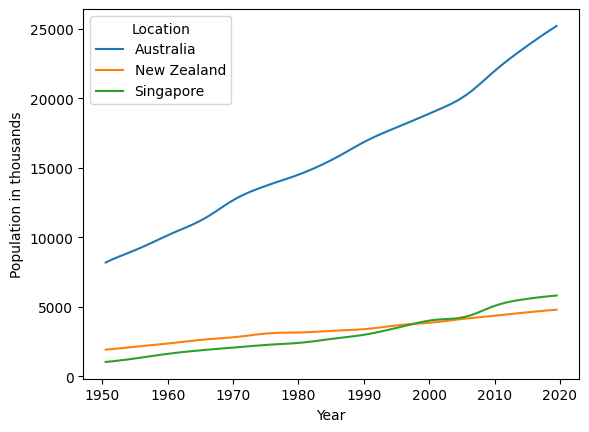

In [39]:
ax = dataforplotting.pivot_table(index=['MidPeriod'], columns='Location', values='Population').plot()
ax.set_xlabel('Year');
ax.set_ylabel('Population in thousands');

**Bonus Exercise**: Plot the world population of children (age 0-17) along with those of the age groups 18-39 and 40+ from 1950 to 2019. You should display three lines (one for the population of each age group vs year) on the same plot. Note that 'World' is one of the locations.

Hint: one approach is to create a new column 'AgeCategory' based on AgeGrpStart using the 'when' function.

In [40]:
# ANSWER
world_data = df[df.Location == "World"]\
                  .withColumn('AgeCategory',\
                              when(df.AgeGrpStart <= 17, '0-17')\
                              .when(df.AgeGrpStart >= 40, '40+')\
                              .otherwise('18-39'))\
                  .select('MidPeriod', 'AgeGrpStart',\
                          'AgeCategory', 'PopTotal') \
                  .groupBy('MidPeriod', 'AgeCategory')\
                  .sum('PopTotal')\
                  .withColumnRenamed('sum(PopTotal)', 'Population')\
                  .withColumn('Population', round('Population', 3))

In [41]:
agegrp_df = world_data.toPandas()

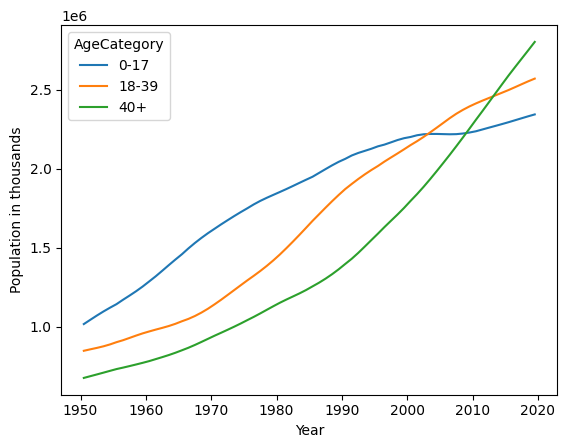

In [42]:
ax = agegrp_df.pivot_table(index=['MidPeriod'], columns='AgeCategory', values='Population').plot()
ax.set_xlabel('Year');
ax.set_ylabel('Population in thousands');

## Population Pyramid

In this section we show how a population pyramid may be created. We look at China in the year 1980.

In [43]:
china_1980 = df.filter((df.Location == 'China (and dependencies)') & (df.Time == 1980)).toPandas()

In [44]:
china_1980

,LocID,Location,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
0,1105,China (and dependencies),1980,1980.5,0,0,1,9345.832031,8896.928711,18242.761719
1,1105,China (and dependencies),1980,1980.5,1,1,1,10080.731445,9500.591797,19581.322266
2,1105,China (and dependencies),1980,1980.5,2,2,1,10769.024414,10093.152344,20862.175781
3,1105,China (and dependencies),1980,1980.5,3,3,1,11404.811523,10664.711914,22069.523438
4,1105,China (and dependencies),1980,1980.5,4,4,1,11982.184570,11205.377930,23187.562500
...,...,...,...,...,...,...,...,...,...,...
96,1105,China (and dependencies),1980,1980.5,96,96,1,1.198000,3.994000,5.192000
97,1105,China (and dependencies),1980,1980.5,97,97,1,0.894000,3.042000,3.936000
98,1105,China (and dependencies),1980,1980.5,98,98,1,0.576000,2.022000,2.598000
99,1105,China (and dependencies),1980,1980.5,99,99,1,0.240000,0.933000,1.173000


In [45]:
china_1980.describe()

,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
count,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,1980.0,1980.5,50.000000,50.000000,0.980198,5200.050293,4929.667969,10129.718750
std,0.0,0.0,29.300171,29.300171,0.199007,4547.521484,4259.914062,8804.997070
min,1980.0,1980.5,0.000000,0.000000,-1.000000,0.169000,0.933000,1.144000
25%,1980.0,1980.5,25.000000,25.000000,1.000000,843.093994,1183.671997,2026.765991
50%,1980.0,1980.5,50.000000,50.000000,1.000000,4447.303223,3898.085938,8345.388672
75%,1980.0,1980.5,75.000000,75.000000,1.000000,9345.832031,8896.928711,18242.761719
max,1980.0,1980.5,100.000000,100.000000,1.000000,14015.841797,13443.602539,27459.445312


Create age brackets in multiples of 5 - such as 0-4, 5-9, ...

In [46]:
lower = china_1980['AgeGrpStart'] - (china_1980['AgeGrpStart'] % 5)

In [47]:
agebrackets = [f'{x:02d}-{(x+4):02d}' for x in lower.values]
agebrackets[-1] = '100+'

In [48]:
agebrackets[:10]

['00-04',
 '00-04',
 '00-04',
 '00-04',
 '00-04',
 '05-09',
 '05-09',
 '05-09',
 '05-09',
 '05-09']

In [49]:
china_1980['AgeRange'] = agebrackets

Next find the populations by age range.

In [50]:
agg_china_1980 = (china_1980.groupby(['AgeRange']).sum()[['PopMale', 'PopFemale']]/1000).reset_index()

<ipython-input-50-5eebe1db66f8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_china_1980 = (china_1980.groupby(['AgeRange']).sum()[['PopMale', 'PopFemale']]/1000).reset_index()


In [51]:
rev_age = list(dict.fromkeys(agebrackets[::-1])) #reversed list of ages

In [52]:
agg_china_1980['NegPopMale'] = -agg_china_1980['PopMale']

We are now ready to plot the population pyramid:

<ipython-input-53-d4fb341c2b66>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(labels)
<ipython-input-53-d4fb341c2b66>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), size = 15);


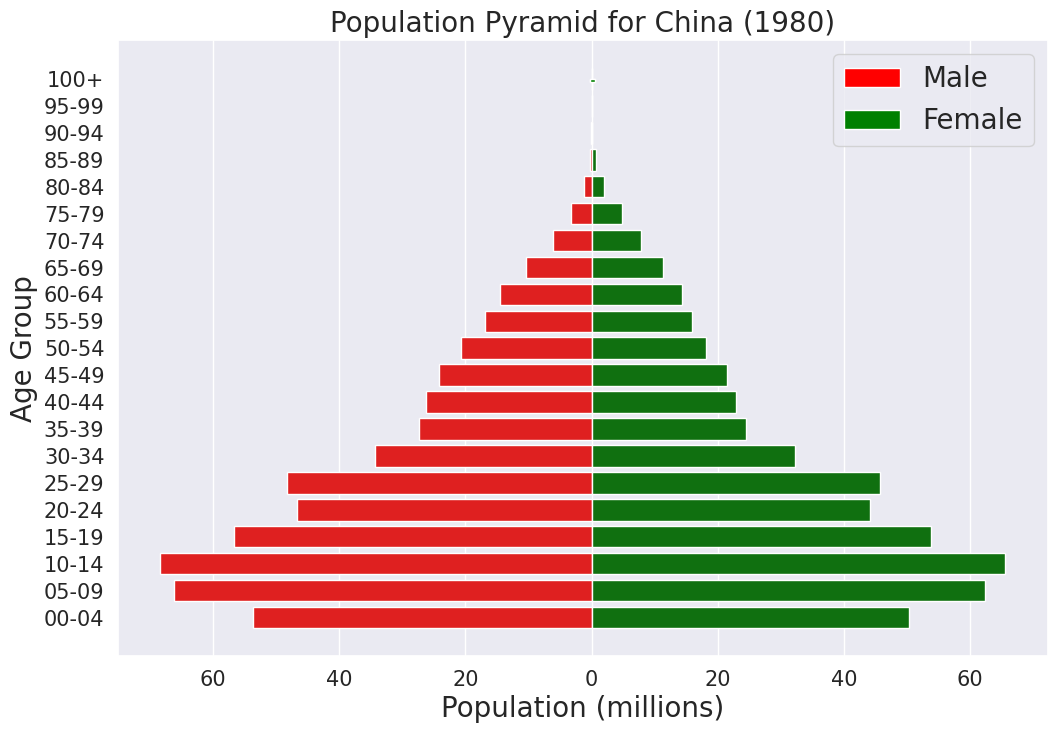

In [53]:
sns.set(rc={'figure.figsize':(12,8)})
bar_plot = sns.barplot(x='NegPopMale', y='AgeRange', data=agg_china_1980, order = rev_age, color='red')
bar_plot = sns.barplot(x='PopFemale', y='AgeRange', data=agg_china_1980, order = rev_age, color='green')

labels = ["80", "60", "40", "20", "0", "20", "40", "60", "80"]
bar_plot.set_xticklabels(labels)

h = [bar_plot.bar(x=.1, height=.1, color = c) for c in ['red', 'green']] #used to set colour of bar in legend
bar_plot.legend(handles = h, labels=['Male', 'Female'], fontsize=20)

bar_plot.axes.set_title("Population Pyramid for China (1980)", fontsize=20);
bar_plot.set_xlabel("Population (millions)", fontsize=20);
bar_plot.set_ylabel("Age Group", fontsize=20);
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), size = 15);
bar_plot.set_yticklabels(bar_plot.get_yticklabels(), size = 15);

## Prediction
Finally we use Spark's MLlib library in a linear regression problem. We shall predict the proportion of population to be of a particular age, given year.

Inputs:
- year
- age

Target variable:
- proportion of a country's population to be of that age, in that year


In [54]:
pop_by_loc_and_year = df.groupBy('Location', 'Time')\
                        .sum('PopTotal')\
                        .withColumnRenamed('sum(PopTotal)', 'Location_year_pop')

In [55]:
pop_by_loc_and_year.show()

+--------------------+----+------------------+
|            Location|Time| Location_year_pop|
+--------------------+----+------------------+
|       African Union|1999| 790628.6244071722|
|African Union: Ea...|1964| 78209.82484335266|
|             Albania|1960|1636.0909999981523|
|              Angola|1979| 8058.111999897286|
|              Angola|1987|10689.246978582349|
| Antigua and Barbuda|1995| 68.67199999373406|
| Antigua and Barbuda|2017|  95.4249999569729|
|           Argentina|2010| 40895.75102710724|
|          Azerbaijan|2012| 9264.683963924646|
|                BRIC|1981| 1991971.387032032|
|               BRICS|1994| 2523968.064731598|
|             Bahamas|1968|158.64800055802334|
|             Bahrain|2014|1336.0730002257042|
|          Bangladesh|1987| 95671.15840621479|
|            Barbados|2019| 287.0210008621216|
|Belt-Road Initiat...|1991| 579859.1757936478|
|Belt-Road Initiat...|1963| 497522.4002505541|
|Belt-Road Initiat...|2018| 1532885.483291626|
|Belt-Road In

In [56]:
trainingset = df.join(pop_by_loc_and_year, ['Location', 'Time'])\
  .withColumn('Proportion',
              df.PopTotal/pop_by_loc_and_year.Location_year_pop)\
  .select('Time', 'AgeGrpStart', 'Proportion')

**Exercise**: Use the stat.corr function to find the correlation between AgeGrpStart and Proportion.

In [57]:
# ANSWER
trainingset.stat.corr("AgeGrpStart", "Proportion") #strong negative correlation

-0.906289636077237

Next we create a simple linear regression model predict Ratio from Time and AgeGrpStart.

In [58]:
from pyspark.ml.regression import LinearRegression

MLlib takes input in vector form. Hence we need to create vectors from features.

In [59]:
from pyspark.ml.feature import VectorAssembler
featureassembler=VectorAssembler(inputCols=['Time', 'AgeGrpStart'],
                                 outputCol='Features')

In [60]:
final_data_for_regression = featureassembler.transform(trainingset).select('Features', 'Proportion')
final_data_for_regression.show()

+-------------+--------------------+
|     Features|          Proportion|
+-------------+--------------------+
| [1999.0,0.0]|0.034861880698940154|
| [1999.0,1.0]|0.033504117654464094|
| [1999.0,2.0]| 0.03229754709870501|
| [1999.0,3.0]|0.031226978883906742|
| [1999.0,4.0]| 0.03036231881608717|
| [1999.0,5.0]|0.029540022684496337|
| [1999.0,6.0]| 0.02879784229235586|
| [1999.0,7.0]|0.028121706557925764|
| [1999.0,8.0]| 0.02749754439946607|
| [1999.0,9.0]|0.026922376581622418|
|[1999.0,10.0]|0.026393226339384863|
|[1999.0,11.0]| 0.02584056829977413|
|[1999.0,12.0]|0.025228194624822717|
|[1999.0,13.0]|0.024575277657470227|
|[1999.0,14.0]| 0.02394366246993583|
|[1999.0,15.0]|0.023328689992668676|
|[1999.0,16.0]|0.022669283430560058|
|[1999.0,17.0]|0.021943661756977005|
|[1999.0,18.0]| 0.02117703730693325|
|[1999.0,19.0]|0.020418749034089554|
+-------------+--------------------+
only showing top 20 rows



In [61]:
train, test = final_data_for_regression.randomSplit([0.9,0.1])

In [62]:
train

DataFrame[Features: vector, Proportion: double]

Next we cache these dataframes into memory:

In [63]:
train = train.cache()

In [64]:
test = test.cache()

We are ready to train the model. This may take a minute or so due to the size of training set.

In [65]:
regressor = LinearRegression(featuresCol='Features', labelCol='Proportion')
regressor = regressor.fit(train)

In [66]:
regressor.coefficients

DenseVector([0.0, -0.0003])

In [67]:
regressor.intercept

0.02285533721326511

In [68]:
predicted_results = regressor.evaluate(test)

Here we can compare some predicted proportions with actual proportions:

In [69]:
predicted_results.predictions.show()

+------------+--------------------+--------------------+
|    Features|          Proportion|          prediction|
+------------+--------------------+--------------------+
|[1950.0,0.0]| 0.01563142323680054|0.022981578131282283|
|[1950.0,0.0]|0.019175293346078377|0.022981578131282283|
|[1950.0,0.0]|0.020410230420568904|0.022981578131282283|
|[1950.0,0.0]|0.023838611374477504|0.022981578131282283|
|[1950.0,0.0]|0.023887483288296953|0.022981578131282283|
|[1950.0,0.0]|0.024091668932129055|0.022981578131282283|
|[1950.0,0.0]|0.026854178459601058|0.022981578131282283|
|[1950.0,0.0]|0.027301460613187913|0.022981578131282283|
|[1950.0,0.0]|0.028562596478128692|0.022981578131282283|
|[1950.0,0.0]| 0.02912177854251887|0.022981578131282283|
|[1950.0,0.0]| 0.03173624142837935|0.022981578131282283|
|[1950.0,0.0]|0.031899008140268206|0.022981578131282283|
|[1950.0,0.0]|0.032461731287096895|0.022981578131282283|
|[1950.0,0.0]| 0.03247022644546615|0.022981578131282283|
|[1950.0,0.0]|0.032749185658808

**Exercise**: Find R-squared and the mean squared error using the 'r2' and 'meanSquaredError' attributes.

In [70]:
# ANSWER
predicted_results.r2, predicted_results.meanSquaredError

(0.8213075601837754, 1.2770376219275275e-05)

## Conclusion

We have seen how to use Pyspark to make queries on a large dataset, save smaller datasets into Pandas dataframe for plotting and how to use MLlib for machine learning on a large dataset.



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



